<center><h1>LEWIS_RYLAN_NATHAN_HW-4</h1></center>
<br>
<br>

Name: Rylan Nathan Lewis 
<br>
Github Username: Rylannat
<br>
USC ID: 8358130873

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
!pip install scikit-learn

In [28]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,auc,roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import statsmodels.api as sm

Get the AReM Data Set

In [3]:
base_dir = os.path.join("../data/AReM/AReM")
activities = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]

### (b) Splitting Data

In [4]:
train_data ={}
test_data ={}

for activity in activities:
    activity_path = os.path.join(base_dir, activity)
    if not os.path.isdir(activity_path):
        continue

    files = sorted([f for f in os.listdir(activity_path) if f .endswith(".csv")])

    if activity in ["bending1", "bending2"]:
        test_files = ['dataset1.csv', 'dataset2.csv']
    else:
        test_files = ['dataset1.csv', 'dataset2.csv', 'dataset3.csv']

    train_data[activity] = []
    test_data[activity] = []

    for f in files:
        file_path = os.path.join(activity_path, f)

        try:
            df = pd.read_csv(file_path, skiprows=4, on_bad_lines = 'skip')
        except Exception as e:
            print(f"Error reading {file_path}")
            continue

        #Data cleaning part: First drops all rows having all fields NaN. Then checks all columns having all fields NaN and drops if exists. 
        #Then it converts all the fields to numeric, and in the case of another datatype (string for example) existing in any of the fields, it converts it to NaN
        #Then it uses forward fill and backward fill methods to fill the newly obtained NaN values from conversion step just before.
        df.dropna(how = "all", inplace = True)
        df.dropna(axis=1,how = 'all', inplace = True)
        df = df.apply(pd.to_numeric, errors = 'coerce')
        df.ffill(inplace = True)
        df.bfill(inplace = True)

        df["activity"] = activity

        if f in test_files:
            test_data[activity].append(df)
        else:
            train_data[activity].append(df)

train_df = pd.concat([pd.concat(v,ignore_index = True) for v in train_data.values()], ignore_index = True)
test_df = pd.concat([pd.concat(v,ignore_index = True) for v in test_data.values()], ignore_index = True)

print(train_df.shape)
print(test_df.shape)

(33117, 8)
(9120, 8)


In [5]:
train_df.columns

Index(['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13',
       'avg_rss23', 'var_rss23', 'activity'],
      dtype='object')

In [6]:
test_df.columns

Index(['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13',
       'avg_rss23', 'var_rss23', 'activity'],
      dtype='object')

In [7]:
train_df

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,activity
0,0,42.00,0.71,21.25,0.43,30.00,0.00,bending1
1,250,41.50,0.50,20.25,1.48,31.25,1.09,bending1
2,500,41.50,0.50,14.25,1.92,33.00,0.00,bending1
3,750,40.75,0.83,15.75,0.43,33.00,0.00,bending1
4,1000,40.00,0.71,20.00,2.74,32.75,0.43,bending1
...,...,...,...,...,...,...,...,...
33112,118750,31.50,1.66,12.50,3.20,14.25,4.44,walking
33113,119000,27.33,1.25,11.33,0.94,20.00,4.00,walking
33114,119250,37.80,7.68,14.20,2.48,17.25,0.83,walking
33115,119500,33.75,1.30,15.75,5.21,16.50,2.69,walking


In [8]:
test_df

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,activity
0,0,39.25,0.43,22.75,0.43,33.75,1.30,bending1
1,250,39.25,0.43,23.00,0.00,33.00,0.00,bending1
2,500,39.25,0.43,23.25,0.43,33.00,0.00,bending1
3,750,39.50,0.50,23.00,0.71,33.00,0.00,bending1
4,1000,39.50,0.50,24.00,0.00,33.00,0.00,bending1
...,...,...,...,...,...,...,...,...
9115,118750,36.00,2.45,17.00,5.10,20.50,0.87,walking
9116,119000,34.33,1.89,15.00,2.45,17.00,2.12,walking
9117,119250,33.00,7.35,14.60,3.14,13.00,5.70,walking
9118,119500,31.67,1.25,11.00,6.16,19.25,2.17,walking


### (c) Feature Extraction

In [9]:
def extraction(df):
    features = {}
    for i, col in enumerate(df.columns[1:-1]):
        data = df[col].astype(float)
        features[f"min{i+1}"] = data.min()
        features[f"max{i+1}"] = data.max()
        features[f"mean{i+1}"] = data.mean()
        features[f"median{i+1}"] = data.median()
        features[f"std{i+1}"] = data.std()
        features[f"1st quart{i+1}"] = data.quantile(0.25)
        features[f"3rd quart{i+1}"] = data.quantile(0.75)
    return features

train_features = []
test_features = []
for activity, train_dataframes in train_data.items():
    for df in train_dataframes:
        training_data_features = extraction(df)
        train_features.append(training_data_features)

training_features = pd.DataFrame(train_features)

for activity, test_dataframes in test_data.items():
    for df in test_dataframes:
        test_data_features = extraction(df)
        test_features.append(test_data_features)

testing_features = pd.DataFrame(test_features)

training_features.insert(0, "Instance", range(1,len(training_features)+1))
testing_features.insert(0, "Instance", range(1,len(testing_features)+1))

In [10]:
training_features

,Instance,min1,max1,mean1,median1,std1,1st quart1,3rd quart1,min2,max2,...,std5,1st quart5,3rd quart5,min6,max6,mean6,median6,std6,1st quart6,3rd quart6
0,1,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,...,1.999604,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400
1,2,33.00,47.75,42.179812,43.500,3.670666,39.15,45.0000,0.0,3.00,...,3.849448,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000
2,3,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,...,2.411026,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000
3,4,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,...,2.488862,22.2500,24.00,0.0,5.26,0.679646,0.500,0.622534,0.43,0.8700
4,5,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,...,3.318301,20.5000,23.75,0.0,2.96,0.555312,0.490,0.487826,0.00,0.8300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,...,3.174681,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050
65,66,21.50,51.00,34.935812,35.500,4.645944,32.00,38.0625,0.0,12.21,...,3.192058,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000
66,67,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,...,3.000493,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200
67,68,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,...,2.905688,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600


In [11]:
testing_features

,Instance,min1,max1,mean1,median1,std1,1st quart1,3rd quart1,min2,max2,...,std5,1st quart5,3rd quart5,min6,max6,mean6,median6,std6,1st quart6,3rd quart6
0,1,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,...,2.188449,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300
1,2,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,...,1.995255,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300
2,3,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,...,3.693786,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870
3,4,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,...,5.053642,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300
4,5,24.25,45.00,37.177042,36.250,3.581301,34.5000,40.2500,0.0,8.58,...,2.890347,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900
5,6,28.75,44.75,37.561187,36.875,3.226507,35.2500,40.2500,0.0,9.91,...,2.727377,18.0000,21.5000,0.0,9.62,2.765896,2.450,1.769203,1.4100,3.770
6,7,22.00,44.67,37.058708,36.000,3.710180,34.5000,40.0625,0.0,14.17,...,3.537144,16.0000,21.0000,0.0,8.55,2.983750,2.570,1.815730,1.5000,4.150
7,8,23.50,30.00,27.716375,27.500,1.442253,27.0000,29.0000,0.0,1.79,...,4.074511,5.5000,10.7500,0.0,4.50,0.734271,0.710,0.613688,0.4300,1.000
8,9,24.75,48.33,44.182937,48.000,7.495615,48.0000,48.0000,0.0,3.11,...,3.274539,2.0000,5.5425,0.0,3.91,0.692771,0.500,0.675781,0.3225,0.940
9,10,48.00,48.25,48.004167,48.000,0.032038,48.0000,48.0000,0.0,0.43,...,3.268502,4.6700,10.0000,0.0,2.50,0.641229,0.500,0.388372,0.4600,0.830


In [12]:
new_dataset = pd.concat([training_features, testing_features], ignore_index = True)
new_dataset['Instance'] = range(1, len(new_dataset) + 1)
new_dataset

,Instance,min1,max1,mean1,median1,std1,1st quart1,3rd quart1,min2,max2,...,std5,1st quart5,3rd quart5,min6,max6,mean6,median6,std6,1st quart6,3rd quart6
0,1,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,...,1.999604,35.3625,36.500,0.0,1.79,0.493292,0.430,0.513506,0.000,0.940
1,2,33.00,47.75,42.179812,43.500,3.670666,39.15,45.0000,0.0,3.00,...,3.849448,30.4575,36.330,0.0,2.18,0.613521,0.500,0.524317,0.000,1.000
2,3,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,...,2.411026,28.4575,31.250,0.0,1.79,0.383292,0.430,0.389164,0.000,0.500
3,4,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,...,2.488862,22.2500,24.000,0.0,5.26,0.679646,0.500,0.622534,0.430,0.870
4,5,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,...,3.318301,20.5000,23.750,0.0,2.96,0.555312,0.490,0.487826,0.000,0.830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,84,35.50,46.25,43.174938,43.670,1.989052,42.50,44.5000,0.0,2.12,...,2.983976,12.7500,16.500,0.0,5.72,0.911979,0.830,0.666161,0.470,1.220
84,85,32.75,47.00,42.760562,44.500,3.398919,41.33,45.3725,0.0,3.34,...,4.296574,13.0000,18.565,0.0,5.73,0.842271,0.710,0.722165,0.430,1.090
85,86,19.33,43.50,34.227771,35.500,4.889576,30.50,37.7500,0.0,14.50,...,3.092094,14.7500,18.670,0.0,9.74,3.394125,3.100,1.792090,2.105,4.425
86,87,12.50,45.00,33.509729,34.125,4.850923,30.50,36.7500,0.0,13.05,...,3.133564,14.6275,18.750,0.0,8.96,3.378479,3.085,1.787360,2.060,4.440


## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

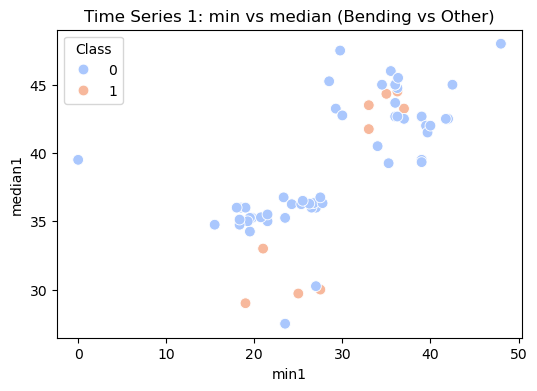

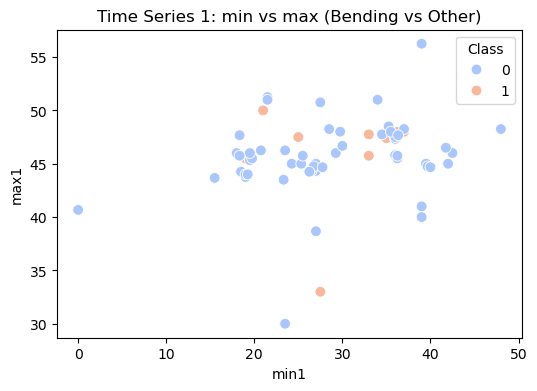

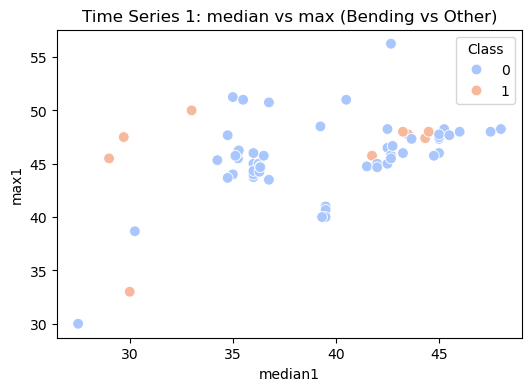

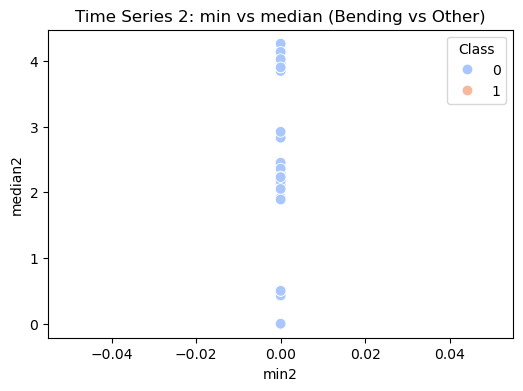

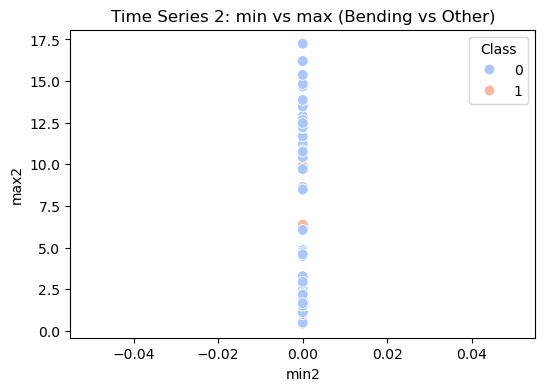

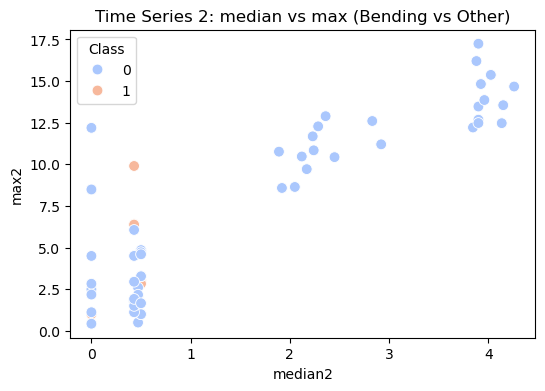

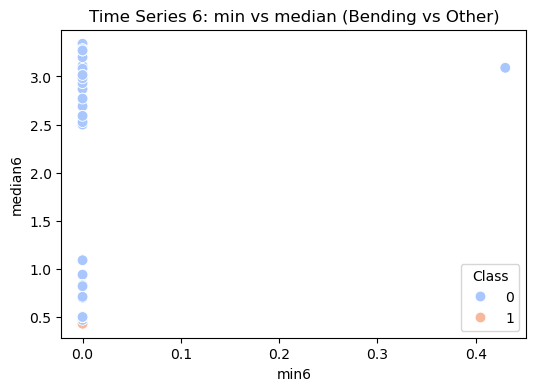

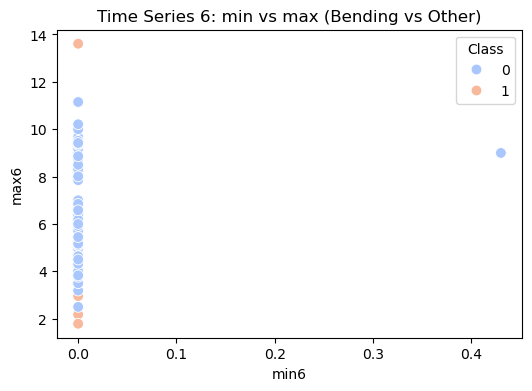

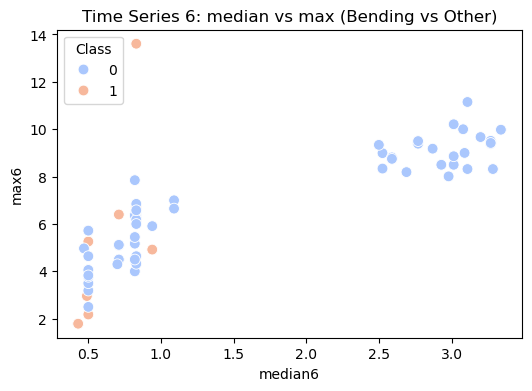

In [13]:
#There are 9 datasets combining bending1 and bending2 for training
N_bending_train = 9

# 1 = bending (bending1 + bending2), 0 = other activities
y = np.array([1]*N_bending_train + [0]*(len(training_features) - N_bending_train))

plot_data = training_features.copy()
plot_data['Class'] = y 

# Function to plot all pairs for a given time series
def plot_feature_pairs(time_series_num):
    features = ['min', 'median', 'max']
    pairs = [('min', 'median'), ('min', 'max'), ('median', 'max')]
    
    for x_feat, y_feat in pairs:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(
            data=plot_data, 
            x=f"{x_feat}{time_series_num}", 
            y=f"{y_feat}{time_series_num}", 
            hue='Class', 
            palette='coolwarm', 
            s=60
        )
        plt.title(f'Time Series {time_series_num}: {x_feat} vs {y_feat} (Bending vs Other)')
        plt.show()

# Scatter plots for time series 1, 2, and 6
for ts in [1, 2, 6]:
    plot_feature_pairs(ts)


#### ii. Splitted Plots

In [14]:
def extraction_split(df):
    features_new = {}
    n_rows = len(df)
    
    # Exclude the first column (time) and last column (activity)
    time_series_cols = df.columns[1:-1]
    
    for i, col in enumerate(time_series_cols):
        data = df[col].astype(float)
        midpoint = n_rows // 2
        
        # Split into two halves
        first_half = data.iloc[:midpoint]
        second_half = data.iloc[midpoint:]
        
        # Features for the first half
        features_new[f"min{i+1}_part1"] = first_half.min()
        features_new[f"max{i+1}_part1"] = first_half.max()
        features_new[f"mean{i+1}_part1"] = first_half.mean()
        features_new[f"median{i+1}_part1"] = first_half.median()
        features_new[f"std{i+1}_part1"] = first_half.std()
        features_new[f"q1_{i+1}_part1"] = first_half.quantile(0.25)
        features_new[f"q3_{i+1}_part1"] = first_half.quantile(0.75)

        # Features for the second half
        features_new[f"min{i+1}_part2"] = second_half.min()
        features_new[f"max{i+1}_part2"] = second_half.max()
        features_new[f"mean{i+1}_part2"] = second_half.mean()
        features_new[f"median{i+1}_part2"] = second_half.median()
        features_new[f"std{i+1}_part2"] = second_half.std()
        features_new[f"q1_{i+1}_part2"] = second_half.quantile(0.25)
        features_new[f"q3_{i+1}_part2"] = second_half.quantile(0.75)
    
    return features_new

train_features_new = []
for activity, train_dataframes in train_data.items():
    for df in train_dataframes:
        training_data_features_new = extraction_split(df)
        train_features_new.append(training_data_features_new)

training_features_new = pd.DataFrame(train_features_new)
training_features_new.insert(0, "Instance", range(1,len(training_features_new)+1))


In [15]:
training_features_new

,Instance,min1_part1,max1_part1,mean1_part1,median1_part1,std1_part1,q1_1_part1,q3_1_part1,min1_part2,max1_part2,...,std6_part1,q1_6_part1,q3_6_part1,min6_part2,max6_part2,mean6_part2,median6_part2,std6_part2,q1_6_part2,q3_6_part2
0,1,36.50,46.50,44.057167,44.500,1.556971,43.2500,45.0000,35.00,47.40,...,0.526656,0.0000,1.0000,0.00,1.50,0.388333,0.000,0.478528,0.0000,0.7100
1,2,33.75,47.75,43.278875,45.000,3.473355,42.0000,45.2500,33.00,46.00,...,0.554542,0.0000,1.2200,0.00,2.18,0.586083,0.470,0.491873,0.0000,0.8700
2,3,33.00,45.75,41.621208,42.330,3.118644,39.6525,44.2500,39.25,43.67,...,0.411200,0.0000,0.7100,0.00,1.50,0.347500,0.430,0.363144,0.0000,0.5000
3,4,39.00,48.00,44.117042,45.000,1.359836,43.5000,45.0000,37.00,46.50,...,0.718016,0.4300,1.1200,0.00,4.06,0.543875,0.500,0.473445,0.4300,0.7100
4,5,36.67,45.00,43.486208,43.710,1.281976,42.3300,44.5000,36.25,48.00,...,0.486847,0.0000,0.8300,0.00,2.96,0.585750,0.500,0.487918,0.4225,0.8300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,22.33,46.00,34.966250,35.500,4.733014,32.0000,38.7500,20.75,46.25,...,1.638218,1.7975,4.2175,0.00,9.39,3.430208,3.350,1.647979,2.1700,4.4400
65,66,21.50,45.67,34.737042,35.500,4.276717,32.0000,37.7500,21.75,51.00,...,1.737573,2.1800,4.5125,0.00,10.21,3.225917,3.085,1.665326,2.0500,4.3500
66,67,18.33,45.00,33.886458,34.375,5.143776,30.4575,37.5000,20.33,47.67,...,1.565557,2.0500,4.2250,0.00,8.01,3.274750,2.955,1.670593,2.0500,4.4375
67,68,18.33,44.00,34.836458,35.750,4.869092,32.0000,38.6900,22.67,45.75,...,1.647640,2.0600,4.1200,0.47,8.84,3.409458,3.110,1.707089,2.1700,4.3450


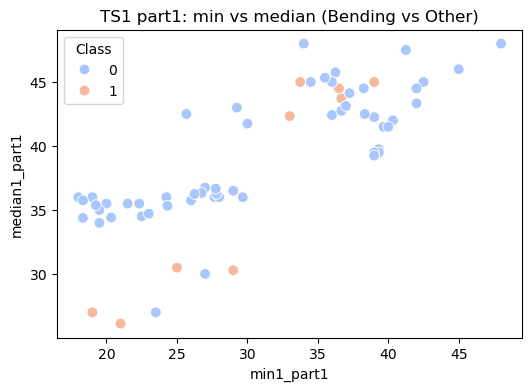

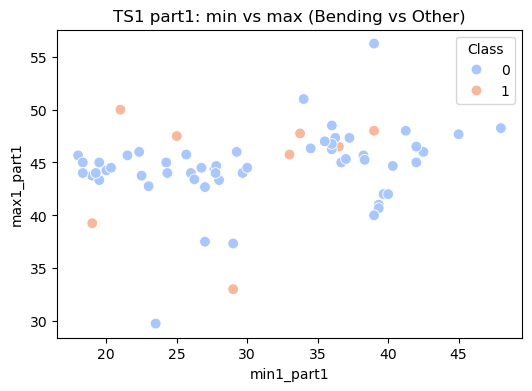

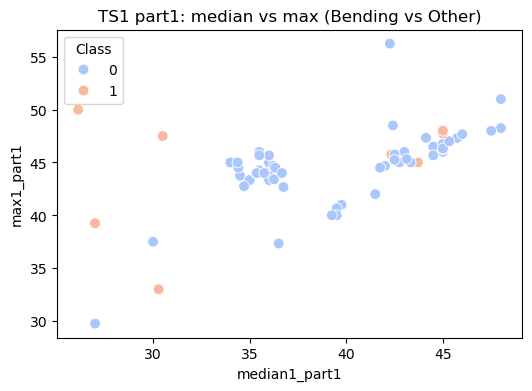

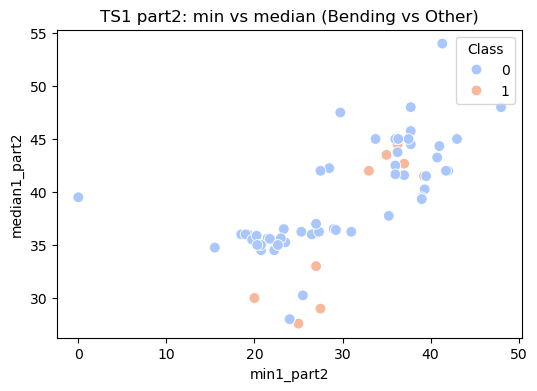

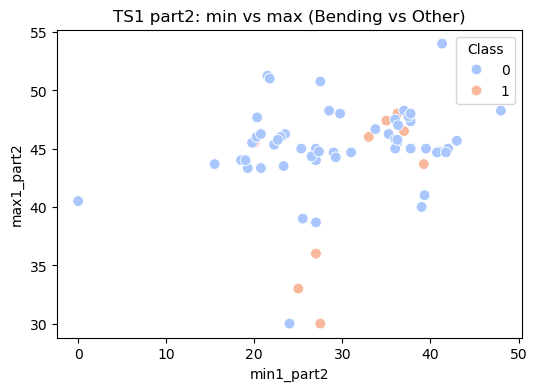

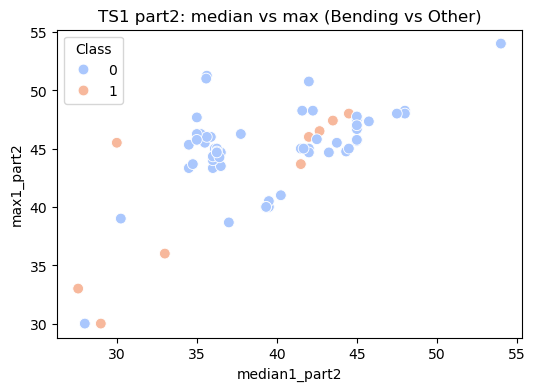

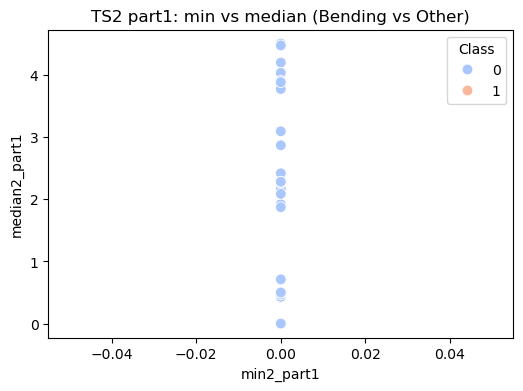

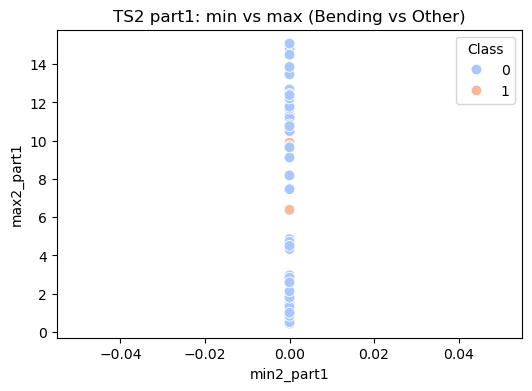

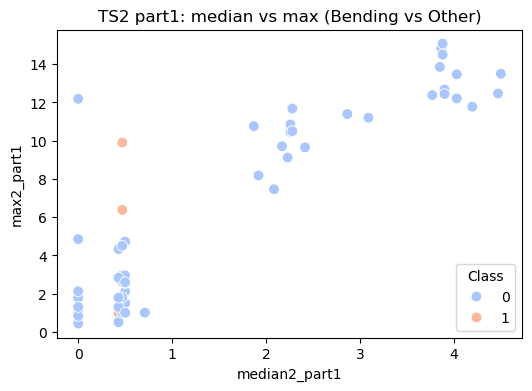

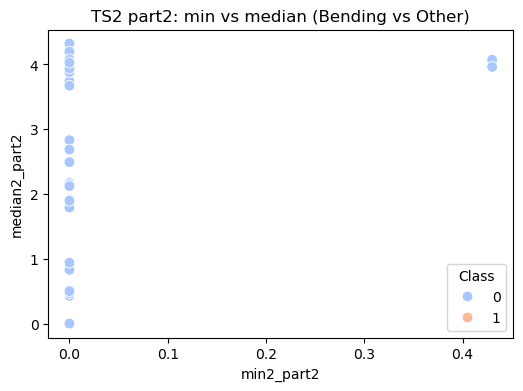

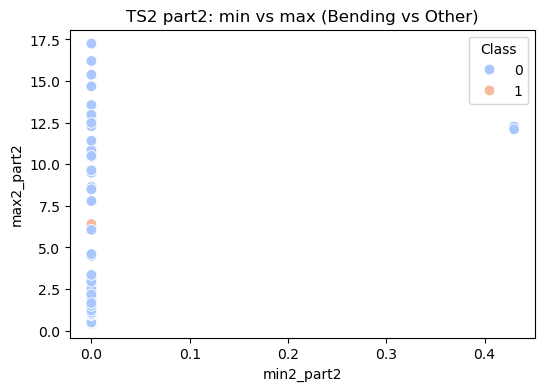

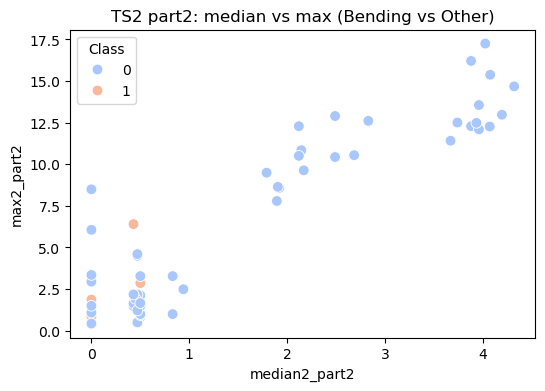

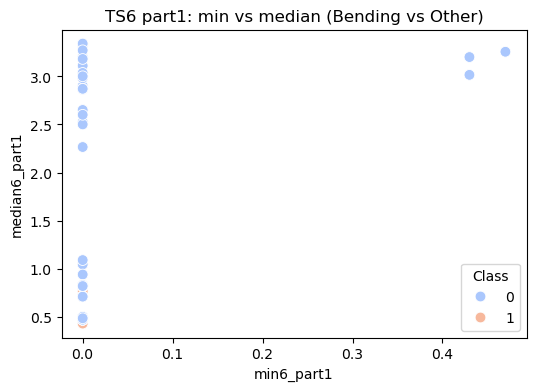

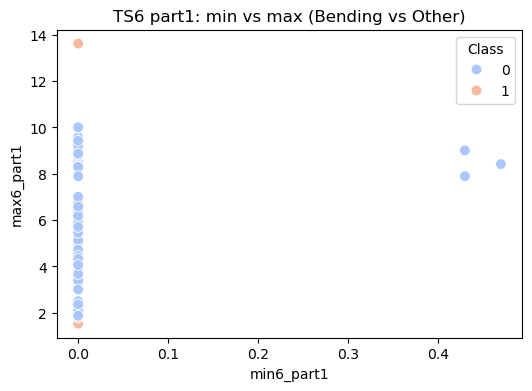

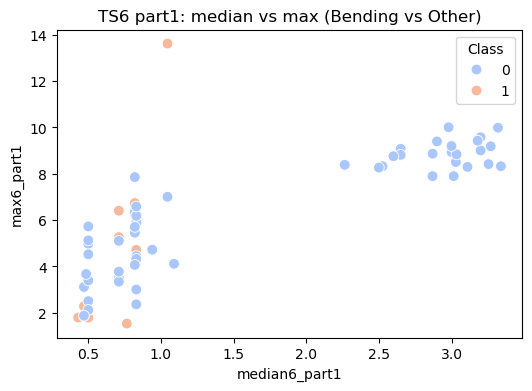

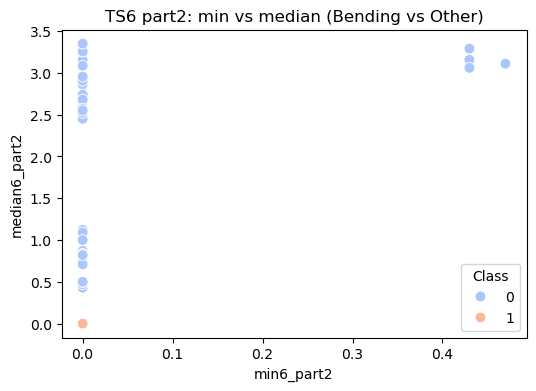

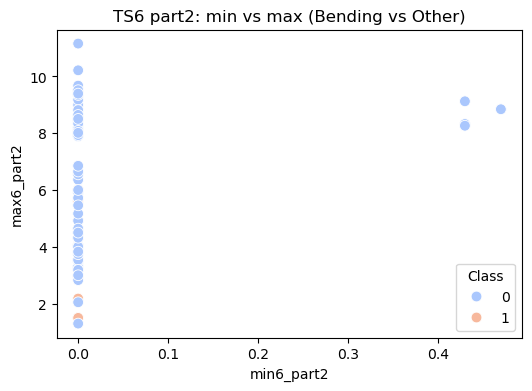

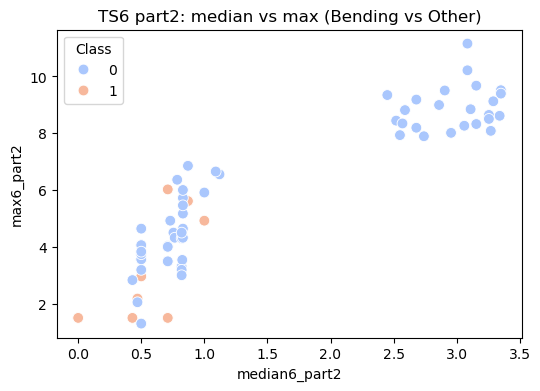

In [16]:
plot_data = training_features_new.copy()
plot_data['Class'] = y

# Define time series to plot
time_series_indices = [1, 2, 6]
halves = ['part1', 'part2']
features_to_plot = [('min', 'median'), ('min', 'max'), ('median','max')]

for ts in time_series_indices:
    for part in halves:
        for x_feat, y_feat in features_to_plot:
            plt.figure(figsize=(6,4))
            sns.scatterplot(
                data=plot_data, 
                x=f"{x_feat}{ts}_{part}", 
                y=f"{y_feat}{ts}_{part}", 
                hue='Class', 
                palette='coolwarm', 
                s=60
            )
            plt.title(f'TS{ts} {part}: {x_feat} vs {y_feat} (Bending vs Other)')
            plt.show()


#### iii. Time Series Segments

The right way to perform cross validation is to extract features within each fold specified (in this case 5). For every train-test split, feature extraction, scaling and model training are done only using the training data for each l value, and then evaluated with the validation data for that specific fold.

The wrong way is to extract features using the entire dataset before performing cross validation as this results in data from the validation set to leak into the training data which then alters the accuracy of the model during validation as it has already seen that data during the training due to its unintended leakage.

In [17]:
#An extraction function that I have defined which I have used for following subquestions to extract the 7 features and create 
#feature vectors for different values of L(segments)
def extract_features_l(df, l):
    feats = {}
    cols = df.columns[1:-1]
    n = len(df)
    base = n // l
    for col in cols:
        data = df[col].values
        for seg in range(l):
            start = seg * base
            end = (seg + 1) * base if seg < l - 1 else n
            segment = data[start:end]
            feats[f"{col}_seg{seg+1}_min"] = np.min(segment)
            feats[f"{col}_seg{seg+1}_max"] = np.max(segment)
            feats[f"{col}_seg{seg+1}_mean"] = np.mean(segment)
            feats[f"{col}_seg{seg+1}_std"] = np.std(segment)
            feats[f"{col}_seg{seg+1}_q1"] = np.percentile(segment, 25)
            feats[f"{col}_seg{seg+1}_q3"] = np.percentile(segment, 75)
    return feats

In [18]:
X_train_raw = []
y_train = []

for activity, dfs in train_data.items():
    for df in dfs:
        X_train_raw.append(df.copy())
        y_train.append(1 if activity in ("bending1", "bending2") else 0)

y_train = np.array(y_train)

#I have defined the Range of L values and used stratifiedKFold here with 5 splits
l_values = range(1, 21)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

#Here I am looping for each L value, and performing: FEATURE EXTRACTION - SCALING - LOG REG - RFECV TO ESTIMATE BEST NUMBER OF FEATURES (P) - UPDATING THE RESULTS
for l in l_values:
    X = pd.DataFrame([extract_features_l(df, l) for df in X_train_raw]).fillna(0)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    base_lr = LogisticRegression(max_iter=1000, solver='lbfgs', C=1e6)
    rfecv = RFECV(estimator=base_lr, cv=cv, scoring='accuracy')
    rfecv.fit(X_scaled, y_train)

    n_selected = rfecv.n_features_

    X_selected_scaled = X_scaled[:, rfecv.support_]
    acc_scores = cross_val_score(base_lr, X_selected_scaled, y_train, cv=cv, scoring='accuracy')
    mean_acc = np.mean(acc_scores)

    results.append({'l': l, 'p': n_selected, 'accuracy': mean_acc})


final_results_5fs = pd.DataFrame(results)
print("\nResult after 5 fold Stratified Cross validation:")
print(final_results_5fs.set_index('l').round(3))


best_lp = final_results_5fs.loc[final_results_5fs['accuracy'].idxmax()]
best_l = int(best_lp['l'])
best_p = int(best_lp['p'])
print(f"\n Best l = {best_l}, No. of features = {best_p}, accuracy = {best_lp['accuracy']:.3f}")



Result after 5 fold Stratified Cross validation:
     p  accuracy
l               
1   10     1.000
2    9     0.971
3    7     0.986
4    1     0.943
5    5     0.986
6    7     1.000
7    5     1.000
8    3     1.000
9   17     1.000
10   8     1.000
11   1     0.971
12   1     0.957
13   4     0.986
14   1     0.943
15   4     1.000
16   6     1.000
17   4     0.986
18   4     1.000
19  10     1.000
20   5     1.000

 Best l = 1, No. of features = 10, accuracy = 1.000


#### iv. Confusion Matrix

Selected features: ['avg_rss12_seg1_min', 'avg_rss12_seg1_q3', 'var_rss12_seg1_max', 'avg_rss13_seg1_q3', 'var_rss13_seg1_max', 'var_rss13_seg1_q1', 'avg_rss23_seg1_min', 'avg_rss23_seg1_max', 'avg_rss23_seg1_mean', 'var_rss23_seg1_q1']

Confusion matrix:
 [[60  0]
 [ 0  9]]
CV AUC:1.0


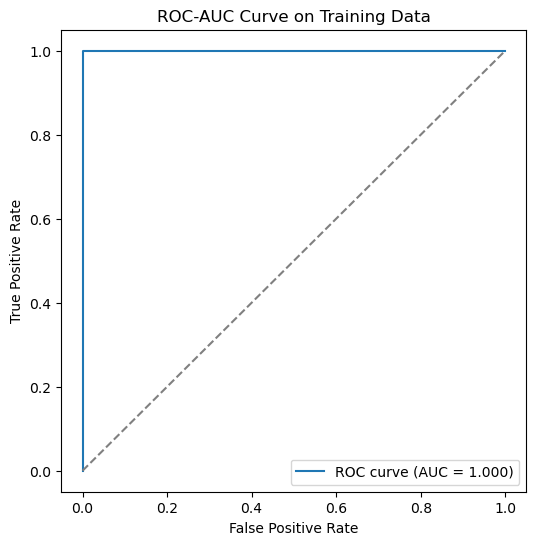

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0048209648711150565
            Iterations: 176
            Function evaluations: 176
            Gradient evaluations: 176
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       59
Method:                           MLE   Df Model:                            9
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                  0.9951
Time:                        16:04:41   Log-Likelihood:               -0.13210
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.712e-08
                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

In [19]:
#In this block I am fitting the model with the pruned set of features from above (L=1 and number of features =10) and then evaluating the model
X_l = pd.DataFrame([extract_features_l(df, best_l) for df in X_train_raw]).fillna(0)
scaler = StandardScaler()
X_scaled_l = scaler.fit_transform(X_l)

rfecv_best_l = RFECV(estimator=base_lr, cv=cv, scoring='accuracy')
rfecv_best_l.fit(X_scaled_l, y_train)

selected_l_features = X_l.columns[rfecv_best_l.support_]
X_selected_scaled_l = X_scaled_l[:, rfecv_best_l.support_]

print(f"Selected features: {list(selected_l_features)}")

final_lr_best = LogisticRegression(max_iter=1000, solver='lbfgs', C=1e6)
final_lr_best.fit(X_selected_scaled_l, y_train)

#cm
y_pred = final_lr_best.predict(X_selected_scaled_l)
cm = confusion_matrix(y_train, y_pred)
print("\nConfusion matrix:\n", cm)

#roc-auc
y_prob = final_lr_best.predict_proba(X_selected_scaled_l)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_prob)
auc = roc_auc_score(y_train, y_prob)
print(f"CV AUC:{auc}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve on Training Data')
plt.legend()
plt.show()

#p vals
X_sm_best = sm.add_constant(pd.DataFrame(X_selected_scaled_l, columns=selected_l_features))
best_l_logit_model = sm.Logit(y_train, X_sm_best).fit_regularized(method='l1', alpha=0.01)
print(best_l_logit_model.summary())

print("\nLogistic regression coefficients:")
print(best_l_logit_model.params)

print("\nP-values for coefficients:")
print(best_l_logit_model.pvalues)


#### v. Test Classifier

Confusion Matrix:
 [[15  0]
 [ 0  4]]
Test set accuracy: 1.000


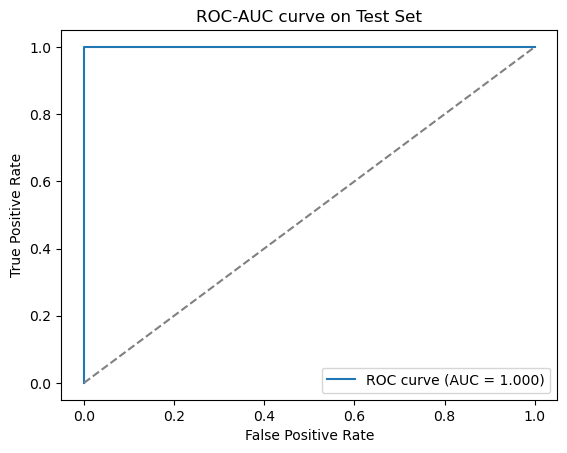

In [20]:
#In this code block, I am testing the model on a completely new test set. So I have built the test features for the best l(1) from test_data 
#which is the raw timeseries data and then selected the features which rfecv selected to accurately test the model.
X_test_raw = []
y_test = []

for activity, dfs in test_data.items():
    for df in dfs:
        X_test_raw.append(df.copy())
        y_test.append(1 if activity in ("bending1", "bending2") else 0)

y_test = np.array(y_test)

X_test_features = pd.DataFrame([extract_features_l(df, best_l) for df in X_test_raw]).fillna(0)

X_test_scaled = scaler.transform(X_test_features)

#here i am using the features that rfecv selected previously
X_test_selected = X_test_scaled[:, [X_test_features.columns.get_loc(f) for f in selected_l_features]]

#here i am using final_lr_best model which was trained above to predict
y_pred = final_lr_best.predict(X_test_selected)
y_prob = final_lr_best.predict_proba(X_test_selected)[:, 1]

#cm
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_acc:.3f}")

#roc-auc curve
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve on Test Set')
plt.legend()

The test set accuracy as well as the cross validation accuracy are EQUAL (1.0)

#### vi. Separation

Since the Logistic regression model shows a very high training accuracy of approximately 97.1% and an ROC-AUC of 0.9981, there is an indication that the two classes (bending vs non bending) are almost perfectly linearly separable. However, this then leads to the issue of instability in estimating regression parameters as the process tries to assign extremely high coefficients to perfectly distinguish between the two classes, resulting in the possibility of the model coefficients becoming unreliable. This problem is defined as quasi-complete separation

#### vii. Imbalance

From the confusion matrix of both train and test, we can see that there is a clear case of class imbalance (60 for non bending, 9 for bending in case of train) (15 for non bending, 4 for bending in case of test).

Train Confusion matrix:
 [[60  0]
 [ 0  9]]
Train AUC: 1.0


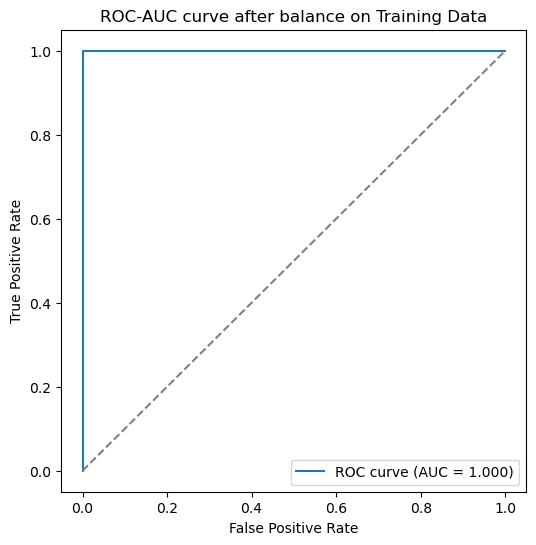

Test Confusion Matrix:
 [[15  0]
 [ 0  4]]
Test AUC:1.0


C:\Users\Rylan Lewis\AppData\Local\Temp\ipykernel_25280\2747634248.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='gray')


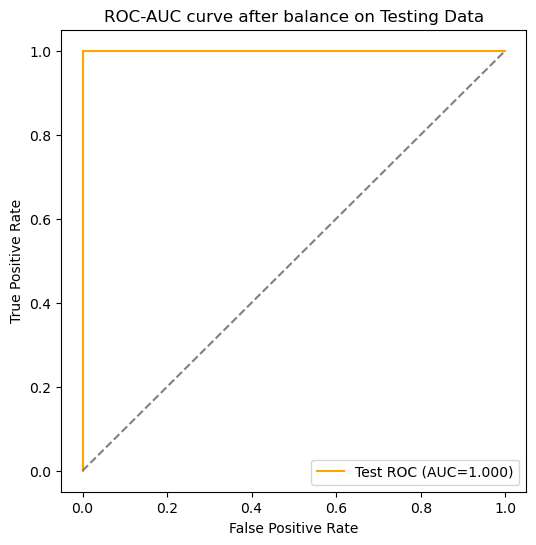

In [21]:
#I have used class_weight = 'balanced' to fix the problem of imbalance, as this assigns inverse frequency weights to each class.
balanced_lr = LogisticRegression(max_iter=1000, solver='lbfgs', C=1e6, class_weight='balanced')
balanced_lr.fit(X_selected_scaled_l, y_train)

y_pred_balanced = balanced_lr.predict(X_selected_scaled_l)
y_prob_balanced = balanced_lr.predict_proba(X_selected_scaled_l)[:, 1]

#cm
cm_balanced = confusion_matrix(y_train, y_pred_balanced)
print("Train Confusion matrix:\n", cm_balanced)

#roc-auc curve
fpr, tpr, thresholds = roc_curve(y_train, y_prob_balanced)
auc_score = roc_auc_score(y_train, y_prob_balanced)
print(f"Train AUC: {auc_score}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve after balance on Training Data')
plt.legend()
plt.show()


X_test_feats = pd.DataFrame([extract_features_l(df, best_l) for df in X_test_raw]).fillna(0)
X_test_feats = X_test_feats.reindex(columns=X_l.columns, fill_value=0)

X_test_scaled = scaler.transform(X_test_feats) 
X_test_selected = X_test_scaled[:, rfecv_best_l.support_]

y_pred_test = balanced_lr.predict(X_test_selected)
y_prob_test = balanced_lr.predict_proba(X_test_selected)[:, 1]

cm_test = confusion_matrix(y_test, y_pred_test)
print("Test Confusion Matrix:\n",cm_test)
auc_test = roc_auc_score(y_test, y_prob_test)
print(f"Test AUC:{auc_test}")

plt.figure(figsize=(6,6))
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC={auc_test:.3f})', color='orange')
plt.plot([0,1], [0,1], 'k--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve after balance on Testing Data')
plt.legend()
plt.show()


### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [22]:
l_values_l1 = range(1, 21)
cv_l1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_l1 = []

for l in l_values_l1:
    # Feature extraction
    X_l1 = pd.DataFrame([extract_features_l(df, l) for df in X_train_raw]).fillna(0)
    scaler = StandardScaler()
    X_scaled_l1 = scaler.fit_transform(X_l1)

    l1_lr = LogisticRegressionCV(
        Cs=np.logspace(-4, 4, 20),                   
        cv=cv_l1,
        penalty='l1',
        solver='liblinear',
        scoring='accuracy',
        max_iter=5000,
        random_state=42
    )

    l1_lr.fit(X_scaled_l1, y_train)
    best_c_l1 = l1_lr.C_[0]
    mean_acc_l1 = np.mean([v.mean() for v in l1_lr.scores_.values()])

    results_l1.append({
        'l': l,
        'best_C': best_c_l1,
        'accuracy': mean_acc_l1,
        'nonzero_coefs': np.sum(l1_lr.coef_ != 0)
    })

# Summarize
final_results_l1 = pd.DataFrame(results_l1)
print("\nL1-Regularized Logistic Regression Cross-Validation Results:")
print(final_results_l1.set_index('l').round(3))

best_lc_l1 = final_results_l1.loc[final_results_l1['accuracy'].idxmax()]
best_l_l1 = int(best_lc_l1['l'])
best_c_l1 = best_lc_l1['best_C']
print(f"\n Best l = {best_l_l1}, Best C = {best_c_l1:.4f}, Accuracy = {best_lc_l1['accuracy']:.3f} , Features = {best_lc_l1['nonzero_coefs']}")


L1-Regularized Logistic Regression Cross-Validation Results:
      best_C  accuracy  nonzero_coefs
l                                    
1      1.624     0.926              8
2     29.764     0.907             10
3      0.234     0.914              5
4    545.559     0.907             32
5      4.281     0.912             16
6     11.288     0.915             17
7      0.616     0.909             10
8     29.764     0.910             21
9      1.624     0.908             16
10  3792.690     0.912            146
11     0.616     0.912              8
12     0.616     0.920              5
13     1.624     0.914              8
14     1.624     0.908             13
15  1438.450     0.907            111
16  1438.450     0.897             97
17    78.476     0.915             40
18    78.476     0.930             32
19   206.914     0.922             60
20    78.476     0.923             29

 Best l = 18, Best C = 78.4760, Accuracy = 0.930 , Features = 32.0



Test Accuracy: 0.947


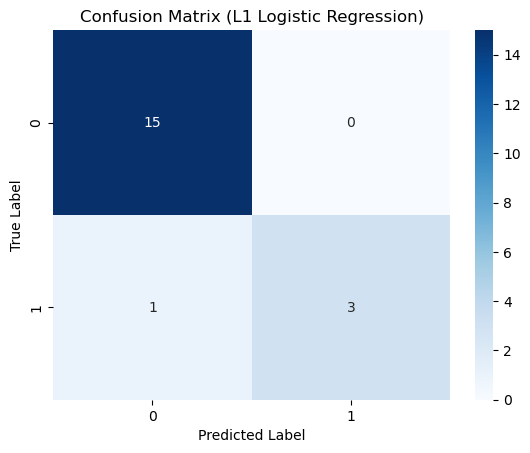


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.75      0.86         4

    accuracy                           0.95        19
   macro avg       0.97      0.88      0.91        19
weighted avg       0.95      0.95      0.94        19



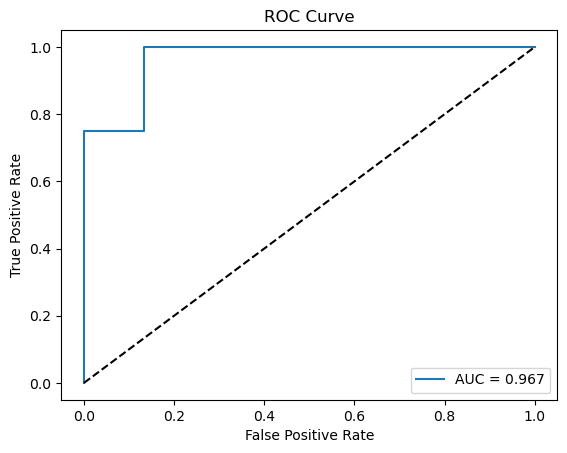

In [23]:
# Extract features with best l
X_train_best = pd.DataFrame([extract_features_l(df, best_l_l1) for df in X_train_raw]).fillna(0)
X_test_best = pd.DataFrame([extract_features_l(df, best_l_l1) for df in X_test_raw]).fillna(0)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test_best)

#Using the final l1 lr model which has been trained to predict on the test set
final_l1_lr = LogisticRegressionCV(
    Cs=[best_c_l1],
    cv=cv_l1,
    penalty='l1',
    solver='liblinear',
    scoring='accuracy',
    max_iter=1000,
    random_state=42
)
final_l1_lr.fit(X_train_scaled, y_train)


y_pred = final_l1_lr.predict(X_test_scaled)
y_prob = final_l1_lr.predict_proba(X_test_scaled)


test_acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_acc:.3f}")

#cm
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (L1 Logistic Regression)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#roc
if len(np.unique(y_test)) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    auc = roc_auc_score(y_test, y_prob[:, 1])
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


#### ii. Comparison

In theory, the L1 logistic regression model should perform better than the normal logistic regression model due to it penalizing large coefficients to help the model generalize better to the data by reducing overfitting due to large parameter coefficients. However, due to reasons like maybe over penalizing causing loss of information, in my assignment the logistic regression performs slightly better than the l1 log reg model, with the normal logistic regression model getting a score of 1 on test data and the l1 log reg model getting a score of 96.7 on the test data. Another reason that the L1 log reg model is unable to generalize well to the lesser class data is maybe due to the evident class imbalance.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

Muti-class classification can be evaluated using:

    a) Confusion Matrix: A confusion matrix is an MxM table where M is the number of classes that the model is trying to predict on. Each row of the confusion matrix represents the actual class (the true label) and each column represents the predicted class by the model on the test data input. In a CM, each M(i,j) represents how many samples from class i were predicted as class j. With the help of a confusion matrix, Accuracy, precision, F1-score , etc. metrics can be calculated to evaluate the model.
    
    b) ROC curve: For a ROC curve for multiclass classification, each class k is treated as a One-Vs-Rest (OvR), where the k class is treated as "positive" and all other classes are treated as "negative". The TPR and TNR are calculated at various threshold and plotted for each class. Then the AUC is computed for each class using either the macro averaging method (average across all classes equally) or Micro averaging method (before calculating TPR and TNR, all the predictors across classes are first aggregated, thus resulting in a weightage based on number of samples per class)

In [24]:
#I have made a new extraction function because now since each class is separate and due to class imbalance, there could be a chance that 
# a specific class might have samples less than l, resulting in empty segments and leading to poor performance of models
def extract_features_l_multi(df, l, train_columns=None):
    features_multi = {}
    cols = df.columns[1:-1] 
    n = len(df)
    base = max(1, n // l)
    for col in cols:
        data = df[col].values
        for seg in range(l):
            start = seg * base
            end = (seg + 1) * base if seg < l - 1 else n
            segment = data[start:end]
            if len(segment) == 0:
                # handle empty segment
                features_multi[f"{col}_seg{seg+1}_min"] = 0
                features_multi[f"{col}_seg{seg+1}_max"] = 0
                features_multi[f"{col}_seg{seg+1}_mean"] = 0
                features_multi[f"{col}_seg{seg+1}_std"] = 0
                features_multi[f"{col}_seg{seg+1}_q1"] = 0
                features_multi[f"{col}_seg{seg+1}_q3"] = 0
            else:
                features_multi[f"{col}_seg{seg+1}_min"] = np.min(segment)
                features_multi[f"{col}_seg{seg+1}_max"] = np.max(segment)
                features_multi[f"{col}_seg{seg+1}_mean"] = np.mean(segment)
                features_multi[f"{col}_seg{seg+1}_std"] = np.std(segment)
                features_multi[f"{col}_seg{seg+1}_q1"] = np.percentile(segment, 25)
                features_multi[f"{col}_seg{seg+1}_q3"] = np.percentile(segment, 75)
    features_multi = pd.Series(features_multi)
    
    # Ensure columns match training columns
    if train_columns is not None:
        features_multi = features_multi.reindex(train_columns, fill_value=0)
    return features_multi


In [25]:
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

X_train_raw_multi = []
y_train_multi = []
activities_list_multi = sorted(train_data.keys()) 

for activity, dfs in train_data.items():
    for df in dfs:
        X_train_raw_multi.append(df.copy())
        y_train_multi.append(activities_list_multi.index(activity)) 

y_train_multi = np.array(y_train_multi)
n_classes = len(np.unique(y_train_multi))


l_values_multi = range(1, 21)
cv_multi = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_multi = []

#Here I am looping for each L value, and performing: FEATURE EXTRACTION - SCALING - LOG REGCV to find best l,lambda(c) - UPDATING THE RESULTS
for l in l_values_multi:
    X_multi = pd.DataFrame([extract_features_l_multi(df, l) for df in X_train_raw_multi]).fillna(0)
    scaler = StandardScaler()
    X_scaled_multi = scaler.fit_transform(X_multi)

    # Multinomial L1 Logistic Regression with CV
    multi_lr = LogisticRegressionCV(
        Cs=10,   #any 10 values that logregcv tries
        cv=cv_multi,
        penalty='l1',
        solver='saga',                
        multi_class='multinomial',
        scoring='accuracy',
        max_iter=5000,
        random_state=42
    )

    multi_lr.fit(X_scaled_multi, y_train_multi)

    best_c_multi = multi_lr.C_[0]

    mean_acc_multi = np.mean([v.mean() for v in multi_lr.scores_.values()])

    results_multi.append({
        'l_multi': l,
        'best_c_multi': best_c_multi,
        'accuracy_multi': mean_acc_multi,
        'nonzero_coefs_multi': np.sum(multi_lr.coef_ != 0)
    })

final_results_multi = pd.DataFrame(results_multi)
print("\nL1-Multinomial Logistic Regression Cross-Validation Results:")
print(final_results_multi.set_index('l_multi').round(3))

best_lc_multi = final_results_multi.loc[final_results_multi['accuracy_multi'].idxmax()]
best_l_multi = int(best_lc_multi['l_multi'])
best_c_multi = best_lc_multi['best_c_multi']
print(f"\nBest l = {best_l_multi}, Best C = {best_c_multi:.4f}, "
      f"Accuracy = {best_lc_multi['accuracy_multi']:.3f}, "
      f"Features = {best_lc_multi['nonzero_coefs_multi']}")


C:\Users\Rylan Lewis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Rylan Lewis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Rylan Lewis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Rylan Lewis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Ryl


L1-Multinomial Logistic Regression Cross-Validation Results:
         best_c_multi  accuracy_multi  nonzero_coefs_multi
l_multi                                                   
1               2.783           0.586                   33
2               2.783           0.612                   47
3              21.544           0.568                  219
4              21.544           0.572                  226
5            1291.550           0.565                 1210
6              21.544           0.550                  334
7               0.359           0.534                   49
8             166.810           0.572                 1519
9              21.544           0.569                  527
10              0.359           0.526                   48
11              0.359           0.545                   46
12             21.544           0.519                  625
13             21.544           0.516                  774
14              2.783           0.520                


Test Accuracy = 0.105, Test Error = 0.895

Confusion Matrix:
[[0 2 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 3 0 0 0 0 0]
 [0 3 0 0 0 0 0]
 [0 3 0 0 0 0 0]
 [0 3 0 0 0 0 0]
 [0 3 0 0 0 0 0]]


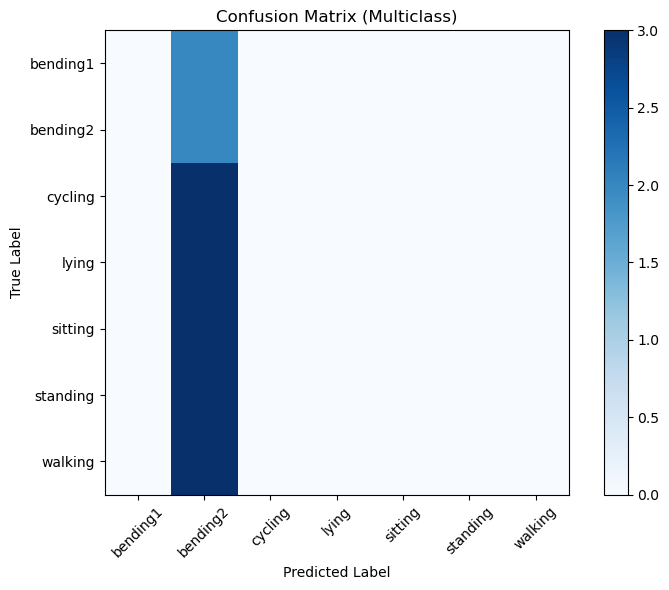

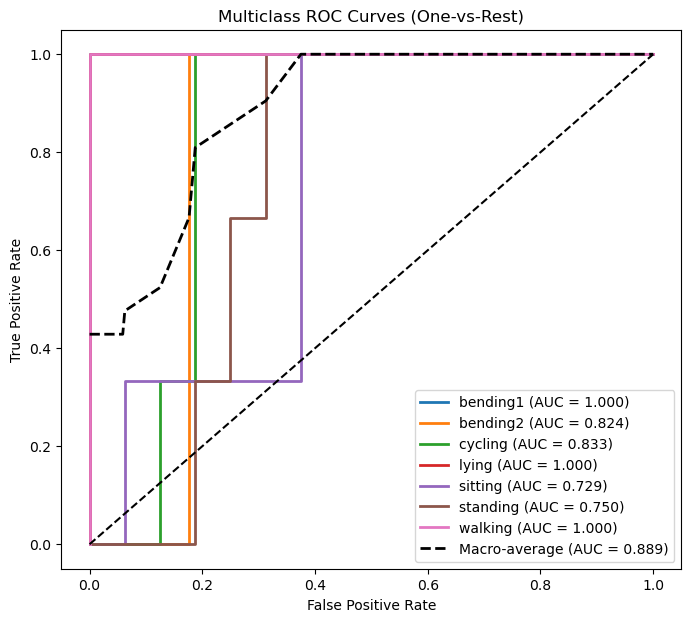

In [29]:
#In this block, I test the model with the best l and faetures on the test data
X_test_raw_multi = []
y_test_multi = []

for activity, dfs in test_data.items():
    for df in dfs:
        X_test_raw_multi.append(df.copy())
        y_test_multi.append(activities_list_multi.index(activity))
        
X_test_features_multi = pd.DataFrame([extract_features_l_multi(df, best_l_multi) for df in X_test_raw_multi]).fillna(0)
X_test_features_multi = X_test_features_multi.reindex(columns=X_multi.columns, fill_value=0)


X_test_scaled_multi = scaler.transform(X_test_features_multi)

y_test_multi = np.array(y_test_multi)

y_pred_multi = multi_lr.predict(X_test_scaled_multi)
y_prob_multi = multi_lr.predict_proba(X_test_scaled_multi)

# multinomiall1lr acc
test_acc_multi = accuracy_score(y_test_multi, y_pred_multi)
test_error_multi = 1 - test_acc_multi
print(f"\nTest Accuracy = {test_acc_multi:.3f}, Test Error = {test_error_multi:.3f}")

# multinomiall1lr cm
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
print("\nConfusion Matrix:")
print(cm_multi)

plt.figure(figsize=(8,6))
plt.imshow(cm_multi, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Multiclass)")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(ticks=range(n_classes), labels=activities_list_multi, rotation=45)
plt.yticks(ticks=range(n_classes), labels=activities_list_multi)
plt.tight_layout()
plt.show()

# multinomiall1lr ROC AUC Curves

from sklearn.preprocessing import label_binarize

# Binarize test labels for multiclass ROC
y_test_bin_multi = label_binarize(y_test_multi, classes=range(n_classes))

fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_multi[:, i], y_prob_multi[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# multinomiall1lr- Macro averaging method for ROC-AUC(1 vs others) method
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(8,7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{activities_list_multi[i]} (AUC = {roc_auc[i]:.3f})')
plt.plot(all_fpr, mean_tpr, color='black', lw=2, linestyle='--', label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


The reason for the poor training and testing accuracies could be the problem of class imbalance, where in the model might be more inclined towards predicting a certain class more than the others due to the evident frequency difference

#### ii. Naive Bayes

In [37]:
warnings.filterwarnings("ignore", category=FutureWarning) # Ignore the UserWarning about least populated class in StratifiedKFold 
warnings.filterwarnings("ignore", category=UserWarning)

X_train_raw_nb = []
y_train_nb = []

activities_list = sorted(train_data.keys())
for activity, dfs in train_data.items():
    for df in dfs:
        X_train_raw_nb.append(df.copy())
        y_train_nb.append(activities_list.index(activity))

y_train_nb = np.array(y_train_nb)

l_values_nb = range(1, 21)
cv_nb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_gaussian = []
results_multinomial = []

for l in l_values_nb:
    X_l = pd.DataFrame([extract_features_l_multi(df, l) for df in X_train_raw_nb]).fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_l)
    
    #This part initializes the GaussianNB classifier
    gnb = GaussianNB()
    acc_scores = []
    for train_idx, val_idx in cv_nb.split(X_scaled, y_train_nb):
        gnb.fit(X_scaled[train_idx], y_train_nb[train_idx])
        y_pred_val = gnb.predict(X_scaled[val_idx])
        acc_scores.append(accuracy_score(y_train_nb[val_idx], y_pred_val))
    
    results_gaussian.append({'l': l, 'accuracy': np.mean(acc_scores)})
    
    #Here, first we convert all features to Non negative as MultinomialNB requires all non-negative fatures, then we initialize the MultinomialNB classifier
    X_l_min = X_l - X_l.min().min()
    mnb = MultinomialNB()
    acc_scores_m = []
    for train_idx, val_idx in cv_nb.split(X_l_min.values, y_train_nb):
        mnb.fit(X_l_min.values[train_idx], y_train_nb[train_idx])
        y_pred_val_m = mnb.predict(X_l_min.values[val_idx])
        acc_scores_m.append(accuracy_score(y_train_nb[val_idx], y_pred_val_m))
    
    results_multinomial.append({'l': l, 'accuracy': np.mean(acc_scores_m)})


df_gaussian = pd.DataFrame(results_gaussian)
df_multinomial = pd.DataFrame(results_multinomial)

best_l_gaussian = df_gaussian.loc[df_gaussian['accuracy'].idxmax(), 'l']
best_l_multinomial = df_multinomial.loc[df_multinomial['accuracy'].idxmax(), 'l']

print("\nGaussian NB Cross-Validation Results:\n", df_gaussian.set_index('l').round(3))
print(f"Best l (Gaussian NB) = {best_l_gaussian}")

print("\nMultinomial NB Cross-Validation Results:\n", df_multinomial.set_index('l').round(3))
print(f"Best l (Multinomial NB) = {best_l_multinomial}")


Gaussian NB Cross-Validation Results:
     accuracy
l           
1      0.857
2      0.813
3      0.696
4      0.740
5      0.696
6      0.667
7      0.711
8      0.696
9      0.637
10     0.680
11     0.624
12     0.623
13     0.595
14     0.640
15     0.566
16     0.568
17     0.552
18     0.568
19     0.538
20     0.552
Best l (Gaussian NB) = 1

Multinomial NB Cross-Validation Results:
     accuracy
l           
1      0.827
2      0.766
3      0.811
4      0.768
5      0.812
6      0.784
7      0.798
8      0.782
9      0.812
10     0.812
11     0.812
12     0.767
13     0.768
14     0.767
15     0.768
16     0.798
17     0.767
18     0.767
19     0.753
20     0.753
Best l (Multinomial NB) = 1


In [31]:
#In this code, I have trained the best Gaussian and Multinomial classifiers using bestl on the training data again
# Gaussian NB
X_train_best_g = pd.DataFrame([extract_features_l_multi(df, best_l_gaussian) for df in X_train_raw_nb]).fillna(0)
scaler_g = StandardScaler()
X_train_scaled_g = scaler_g.fit_transform(X_train_best_g)
gnb_final = GaussianNB()
gnb_final.fit(X_train_scaled_g, y_train_nb)

# Multinomial NB
X_train_best_m = pd.DataFrame([extract_features_l_multi(df, best_l_multinomial) for df in X_train_raw_nb]).fillna(0)
X_train_best_m_shift = X_train_best_m - X_train_best_m.min().min()  # ensure non-negative
mnb_final = MultinomialNB()
mnb_final.fit(X_train_best_m_shift, y_train_nb)

MultinomialNB()

Gaussian NB - Train Accuracy: 1.000, Test Accuracy: 0.895

Gaussian NB - Train Confusion Matrix:
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]

Gaussian NB - Test Confusion Matrix:
 [[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


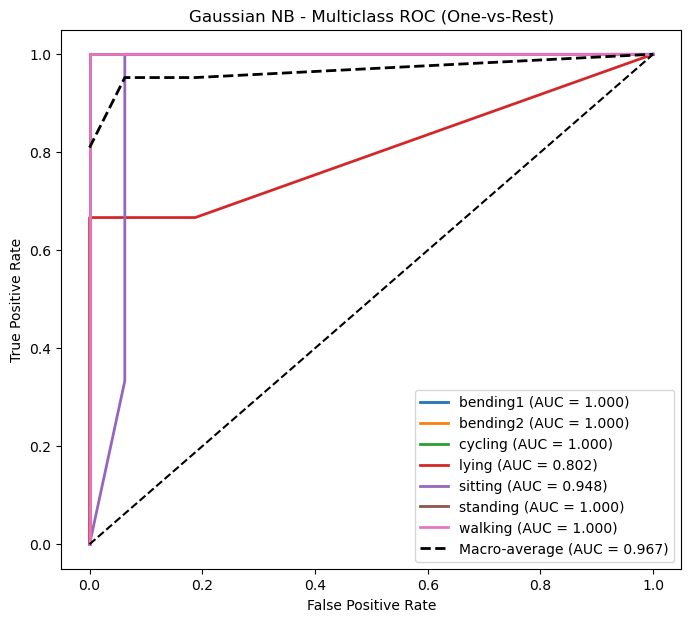


Multinomial NB - Train Accuracy: 0.928, Test Accuracy: 0.895

Multinomial NB - Train Confusion Matrix:
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  1 10  0  0]
 [ 0  0  0  0  2 10  0]
 [ 0  0  0  0  0  0 12]]

Multinomial NB - Test Confusion Matrix:
 [[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]


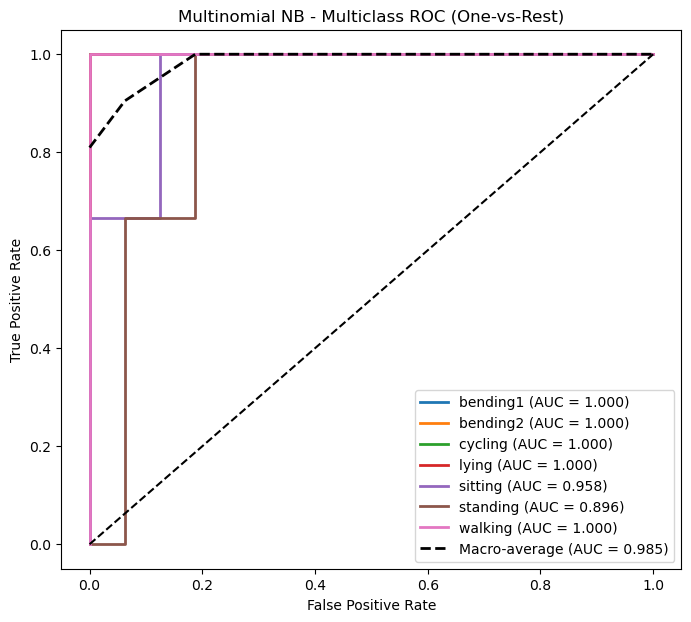

In [32]:
#In this code, I have tested the trained classifiers on the test data and created metrics of evaluation
X_test_raw_nb = []
y_test_nb = []

for activity, dfs in test_data.items():
    for df in dfs:
        X_test_raw_nb.append(df.copy())
        y_test_nb.append(activities_list.index(activity))

y_test_nb = np.array(y_test_nb)
n_classes = len(activities_list)


#Gaussian Testing
X_test_best_g = pd.DataFrame([extract_features_l_multi(df, best_l_gaussian) for df in X_test_raw_nb]).fillna(0)
X_test_scaled_g = scaler_g.transform(X_test_best_g)

y_pred_train_g = gnb_final.predict(X_train_scaled_g)
y_pred_test_g = gnb_final.predict(X_test_scaled_g)

#Gaussian acc
acc_train_g = accuracy_score(y_train_nb, y_pred_train_g)
acc_test_g = accuracy_score(y_test_nb, y_pred_test_g)
print(f"Gaussian NB - Train Accuracy: {acc_train_g:.3f}, Test Accuracy: {acc_test_g:.3f}")

#Gaussian cm
cm_train_g = confusion_matrix(y_train_nb, y_pred_train_g)
cm_test_g = confusion_matrix(y_test_nb, y_pred_test_g)

print("\nGaussian NB - Train Confusion Matrix:\n", cm_train_g)
print("\nGaussian NB - Test Confusion Matrix:\n", cm_test_g)

# Gaussian ROC AUC
y_train_bin = label_binarize(y_train_nb, classes=range(n_classes))
y_test_bin = label_binarize(y_test_nb, classes=range(n_classes))
y_train_prob_g = gnb_final.predict_proba(X_train_scaled_g)
y_test_prob_g = gnb_final.predict_proba(X_test_scaled_g)

fpr_g, tpr_g, roc_auc_g = {}, {}, {}

for i in range(n_classes):
    fpr_g[i], tpr_g[i], _ = roc_curve(y_test_bin[:, i], y_test_prob_g[:, i])
    roc_auc_g[i] = auc(fpr_g[i], tpr_g[i])

#Gaussian- Macro averaging method for ROC-AUC(1 vs others) method
all_fpr = np.unique(np.concatenate([fpr_g[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_g[i], tpr_g[i])
mean_tpr /= n_classes
roc_auc_g["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(8,7))
for i in range(n_classes):
    plt.plot(fpr_g[i], tpr_g[i], lw=2, label=f'{activities_list[i]} (AUC = {roc_auc_g[i]:.3f})')
plt.plot(all_fpr, mean_tpr, color='black', lw=2, linestyle='--', label=f'Macro-average (AUC = {roc_auc_g["macro"]:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Gaussian NB - Multiclass ROC (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

#Multinomial evaluation
# Extract features for test using the best l and shift to non-negative
X_test_best_m = pd.DataFrame([extract_features_l_multi(df, best_l_multinomial) for df in X_test_raw_nb]).fillna(0)
X_test_best_m_shift = X_test_best_m - X_train_best_m.min().min()  # same shift as train


y_pred_train_m = mnb_final.predict(X_train_best_m_shift)
y_pred_test_m = mnb_final.predict(X_test_best_m_shift)

# Multinomial Acc
acc_train_m = accuracy_score(y_train_nb, y_pred_train_m)
acc_test_m = accuracy_score(y_test_nb, y_pred_test_m)
print(f"\nMultinomial NB - Train Accuracy: {acc_train_m:.3f}, Test Accuracy: {acc_test_m:.3f}")

# Multinomial cm
cm_train_m = confusion_matrix(y_train_nb, y_pred_train_m)
cm_test_m = confusion_matrix(y_test_nb, y_pred_test_m)

print("\nMultinomial NB - Train Confusion Matrix:\n", cm_train_m)
print("\nMultinomial NB - Test Confusion Matrix:\n", cm_test_m)

# Multinomial ROC AUC
y_train_prob_m = mnb_final.predict_proba(X_train_best_m_shift)
y_test_prob_m = mnb_final.predict_proba(X_test_best_m_shift)

fpr_m, tpr_m, roc_auc_m = {}, {}, {}
for i in range(n_classes):
    fpr_m[i], tpr_m[i], _ = roc_curve(y_test_bin[:, i], y_test_prob_m[:, i])
    roc_auc_m[i] = auc(fpr_m[i], tpr_m[i])

#Multinomial- Macro averaging method for ROC-AUC(1 vs others) method
all_fpr_m = np.unique(np.concatenate([fpr_m[i] for i in range(n_classes)]))
mean_tpr_m = np.zeros_like(all_fpr_m)
for i in range(n_classes):
    mean_tpr_m += np.interp(all_fpr_m, fpr_m[i], tpr_m[i])
mean_tpr_m /= n_classes
roc_auc_m["macro"] = auc(all_fpr_m, mean_tpr_m)

# Plot ROC
plt.figure(figsize=(8,7))
for i in range(n_classes):
    plt.plot(fpr_m[i], tpr_m[i], lw=2, label=f'{activities_list[i]} (AUC = {roc_auc_m[i]:.3f})')
plt.plot(all_fpr_m, mean_tpr_m, color='black', lw=2, linestyle='--', label=f'Macro-average (AUC = {roc_auc_m["macro"]:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multinomial NB - Multiclass ROC (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


#### ii. Comparison

The Gaussian NB or the Multinomial NB are the best models to be used in this case, as it has the best test accuracy of 89.5 on the test data. Multinomial and Gaussian NB models are simpler and less sensitive to feature sparsity or small sample segments and therefore are more suited for multiclass problems, whereas L1 multinomial logistic regression tends to over-penalize features and do worse when features are sparse or highly correlated, as it is happening in this case. 

## 3. ISLR 4.8.3

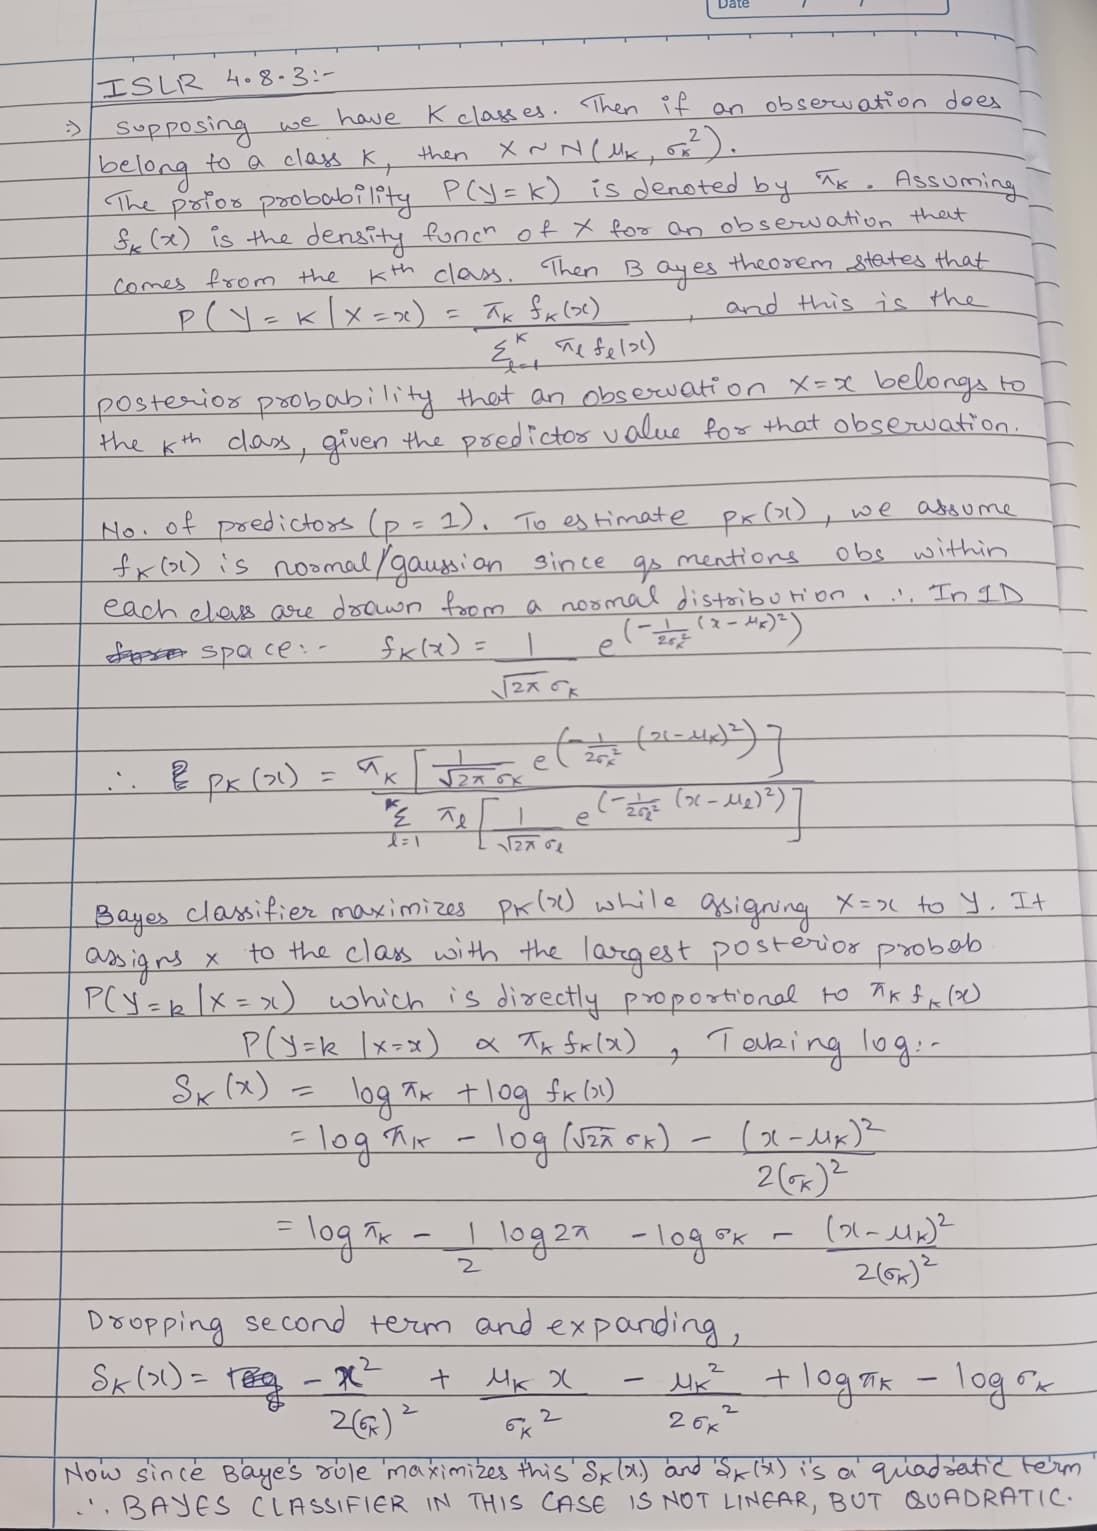

## 4. ISLR 4.8.7

In [33]:
#Given: 
Xmeandiv = 10.0

Xmeannodiv = 0.0 

Var = 36.0 

Pidiv = 0.8 

Pinodiv = 0.2

x = 4.0

#To find: P(Y = 1 | X = 4)

In [34]:
f0  = ((1 / ((math.sqrt(2 * math.pi)) * 6))) * math.exp(-((x - Xmeannodiv) ** 2) / (2 * Var))

In [35]:
f1  = ((1 / ((math.sqrt(2 * math.pi)) * 6))) * math.exp(-((x - Xmeandiv) ** 2) / (2 * Var))

In [36]:
Pr = (Pidiv * f1) / ((Pinodiv * f0) + (Pidiv * f1))
print(Pr)

0.7518524532975261


Assuming that X follows a normal distribution, the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year is around 75.18%

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9